# Own CNN Approach

Notes ...

## Imports and inital setup

In [2]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.metrics import AUC, Precision, Recall

from keras.layers import Conv2D, MaxPool2D, Input, GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout
import tensorflow as tf

import sys

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 684651
NUM_EPOCHS = 5

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx_binary"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

### Loading (augmented) metadata as test, train, validation from files

In [3]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
3178,HAM_0005325,ISIC_0024971.jpg,bkl,histo,50.0,male,neck,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0024971.jpg
1601,HAM_0003887,ISIC_0032857.jpg,bcc,histo,65.0,male,face,vidir_modern,skin_cancer,./../data/jpgs/ISIC_0032857.jpg
4428,HAM_0001920,aug_cXG1l0ISIC_0031901.jpg,vasc,histo,55.0,male,back,vidir_modern,not_skin_cancer,./../data/jpgs/aug_cXG1l0ISIC_0031901.jpg
157,HAM_0005516,ISIC_0028748.jpg,nv,follow_up,50.0,male,abdomen,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0028748.jpg
4746,HAM_0003290,aug_qDPMhbISIC_0031358.jpg,df,histo,80.0,male,upper extremity,rosendahl,not_skin_cancer,./../data/jpgs/aug_qDPMhbISIC_0031358.jpg
1790,HAM_0005304,ISIC_0026056.jpg,bcc,histo,80.0,male,face,rosendahl,skin_cancer,./../data/jpgs/ISIC_0026056.jpg
449,HAM_0004485,ISIC_0031481.jpg,nv,histo,35.0,female,lower extremity,vienna_dias,not_skin_cancer,./../data/jpgs/ISIC_0031481.jpg
1039,HAM_0000179,ISIC_0032550.jpg,mel,histo,45.0,male,back,vidir_modern,skin_cancer,./../data/jpgs/ISIC_0032550.jpg
1943,HAM_0000082,aug_ZZdaDMISIC_0031698.jpg,bcc,histo,75.0,female,back,rosendahl,skin_cancer,./../data/jpgs/aug_ZZdaDMISIC_0031698.jpg
2110,HAM_0002069,aug_q1hkw0ISIC_0029331.jpg,bcc,histo,50.0,male,lower extremity,rosendahl,skin_cancer,./../data/jpgs/aug_q1hkw0ISIC_0029331.jpg


## Setting up the image data generator for training and validation

In [4]:
def custom_preprocessing(np_image, image_size):
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image
    return np_image

In [5]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0, # Rescale pixel values to [0, 1], important for CNNs to perform better
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 2003 validated image filenames belonging to 2 classes.


Found 5256 validated image filenames belonging to 2 classes.


# Adding an neural network model to test the data

## Own Model Architecture

In [6]:
def conv2d_with_Batch(prev_layer , nbr_kernels , filter_size , strides = (1,1) , padding = 'valid'):
    x = Conv2D(filters = nbr_kernels, kernel_size = filter_size, strides=strides , padding=padding) (prev_layer)
    x = BatchNormalization()(x)
    x = Activation(activation = 'relu') (x)
    return x

In [7]:
def residual_block(prev_layer, nbr_kernels, filter_size, padding='same'):
    residual = prev_layer

    # First convolutional layer
    x = tf.keras.layers.Conv2D(nbr_kernels, filter_size, padding='same')(prev_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Second convolutional layer
    x = tf.keras.layers.Conv2D(nbr_kernels, filter_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Ensure the residual is of the same shape as x
    # If not, apply a 1x1 convolution to it
    if residual.shape[-1] != nbr_kernels:
        residual = tf.keras.layers.Conv2D(nbr_kernels, (1, 1), padding='same')(residual)

    # Add the residual connection
    x = tf.keras.layers.add([x, residual])

    # Pooling layer
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)

    return x

In [8]:
# Input layer
input_layer = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Convolutional block 1
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Convolutional block 2
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Convolutional block 3 
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Convolutional block 4
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Convolutional block 5 // new
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Residual block added X addded new wit 512
x = residual_block(x, 512, (3, 3))

# Residual block 
x = residual_block(x, 256, (3, 3))

# Global average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Flatten the output of the convolutional layers // removed here
# x = tf.keras.layers.Flatten()(x)

# Additional Dense (fully connected) layers / new
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Dropout layer
x = tf.keras.layers.Dropout(0.5)(x) 

# Additional Dense (fully connected) as is
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Dropout layer
x = tf.keras.layers.Dropout(0.2)(x) 

# Output layer
output_layer = tf.keras.layers.Dense(train_df[TARGET_LABEL].nunique(), activation='sigmoid')(x)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Stfn-CNN_accuracy')

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

# Summary of the model architecture
model.summary()

Model: "Stfn-CNN_accuracy"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2

## Model Training

In [9]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=None,                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/5
165/165 [==============================] - 278s 2s/step - loss: 0.7137 - accuracy: 0.5603 - auc: 0.5558 - precision: 0.5535 - recall: 0.5531 - val_loss: 0.6577 - val_accuracy: 0.8048 - val_auc: 0.8048 - val_precision: 0.8048 - val_recall: 0.8048
Epoch 2/5
165/165 [==============================] - 219s 1s/step - loss: 0.6837 - accuracy: 0.5713 - auc: 0.5623 - precision: 0.5713 - recall: 0.5713 - val_loss: 0.6319 - val_accuracy: 0.8048 - val_auc: 0.8065 - val_precision: 0.8048 - val_recall: 0.8048
Epoch 3/5
165/165 [==============================] - 223s 1s/step - loss: 0.6832 - accuracy: 0.5713 - auc: 0.5680 - precision: 0.5713 - recall: 0.5713 - val_loss: 0.6204 - val_accuracy: 0.8048 - val_auc: 0.8057 - val_precision: 0.8048 - val_recall: 0.8048
Epoch 4/5
165/165 [==============================] - 221s 1s/step - loss: 0.6835 - accuracy: 0.5713 - auc: 0.5591 - precision: 0.5713 - recall: 0.5713 - val_loss: 0.6196 - val_accuracy: 0.8048 - val_auc: 0.8048 - val_precision: 0.80

## Plotting accuracy and loss of train and validation set

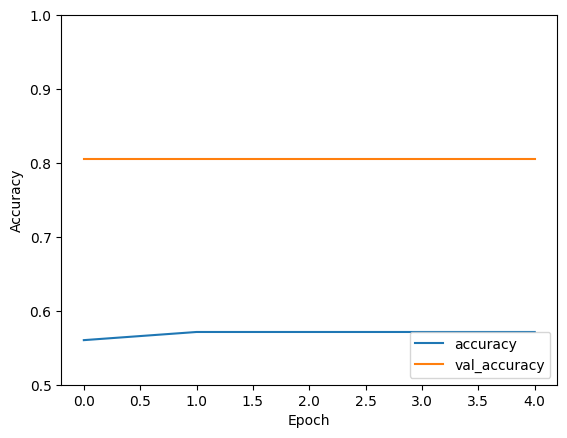

In [10]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

 > Evaluating model Stfn-CNN_accuracy:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
63/63 [==============================] - 16s 254ms/step
 > Model predictions obtained.
 > ROC AUC: 0.53408420224277


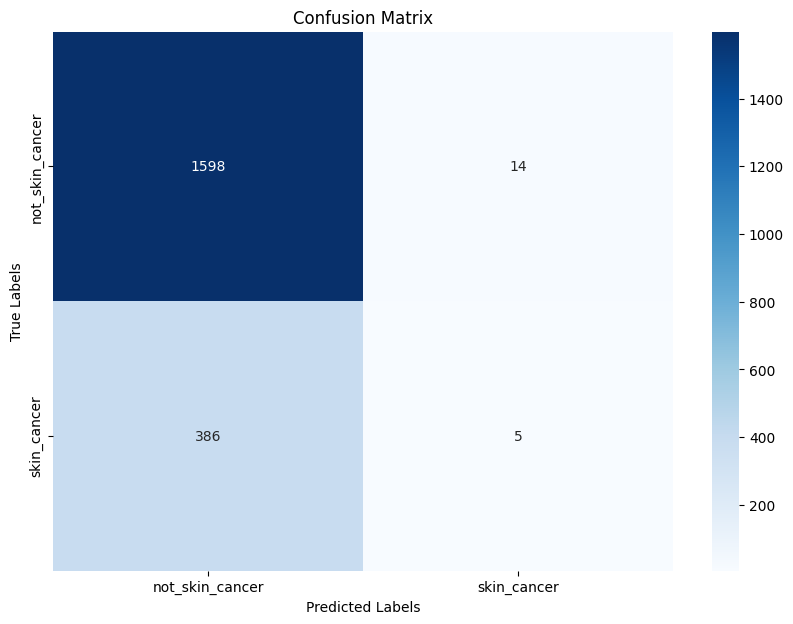



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1612
           1       0.26      0.01      0.02       391

    accuracy                           0.80      2003
   macro avg       0.53      0.50      0.46      2003
weighted avg       0.70      0.80      0.72      2003

 > Evaluating model on test set...
63/63 [==============================] - 16s 255ms/step - loss: 1.1747 - accuracy: 0.8003 - auc: 0.8065 - precision: 0.6037 - recall: 0.9081
loss: 1.1746740341186523
accuracy: 0.8002995252609253
auc: 0.8065493702888489
precision: 0.6037172079086304
recall: 0.9081377983093262
 > Done.


([{'loss': 1.1746740341186523},
  {'accuracy': 0.8002995252609253},
  {'auc': 0.8065493702888489},
  {'precision': 0.6037172079086304},
  {'recall': 0.9081377983093262}],
 array([[1598,   14],
        [ 386,    5]]),
 0.53408420224277)

In [11]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [12]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Continue Training (optional)

In [13]:
# Continue training for another 10 epochs
additional_epochs = 10
continue_training = False

if continue_training:
    history_continued = model.fit(
        train_data_generator,
        steps_per_epoch=None,
        epochs=NUM_EPOCHS + additional_epochs,
        initial_epoch=NUM_EPOCHS,  # start from the epoch after your last training session
        validation_data=validation_generator)


In [14]:
if continue_training:
    mh.model_plot_accuracy(history_continued)

In [15]:
if continue_training:
    mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

In [16]:
if continue_training:
    from datetime import datetime
    timestamp = datetime.now()
    model_path = f"../models/model_{timestamp}.h5"
    model.save(model_path)